# EDA and Visualizations for Monte Carlo simulation

In [325]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
from risk_metrics import compute_var, compute_cvar
import pandas as pd
import numpy as np

**Loss simulation**

In [327]:
from simulate import simulate_portfolio_losses
import numpy as np

mu = np.load("../data/mu.npy")
sigma = np.load("../data/sigma.npy")
weights = np.ones_like(mu) / len(mu)
tickers = ['AMZN', 'SBUX', 'NKE', 'AAPL', 'TSLA', 'GOOGL', 'META', 'WMT', 'ADDYY']

losses = simulate_portfolio_losses(mu, sigma, weights, T=10, N=10000)
var_95 = compute_var(losses, 0.95)
cvar_95 = compute_cvar(losses, 0.95)

for ticker, loss in zip(tickers, losses):
    print(f"{ticker}: {loss:.4f}")




AMZN: 0.0102
SBUX: 0.0260
NKE: -0.0283
AAPL: 0.0154
TSLA: 0.0292
GOOGL: -0.0344
META: 0.0251
WMT: -0.0764
ADDYY: -0.0218


- We are able to see that the most risky stocks, purely based for the next 10 days, are SBUX and TSLA
- The least risky stocks are NKE and WMT

**Histogram of data**

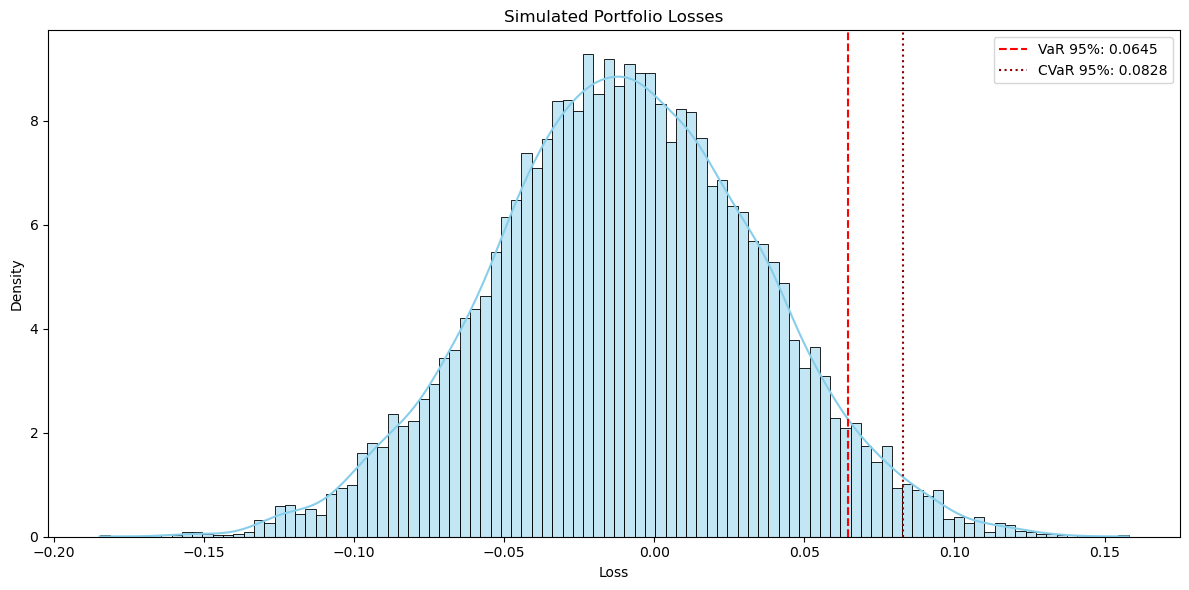

In [328]:
plt.figure(figsize=(12, 6))
sns.histplot(losses, bins=100, kde=True, color='skyblue', stat='density')
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95:.4f}')
plt.axvline(cvar_95, color='darkred', linestyle=':', label=f'CVaR 95%: {cvar_95:.4f}')
plt.title('Simulated Portfolio Losses')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


**Correlation Heatmap**

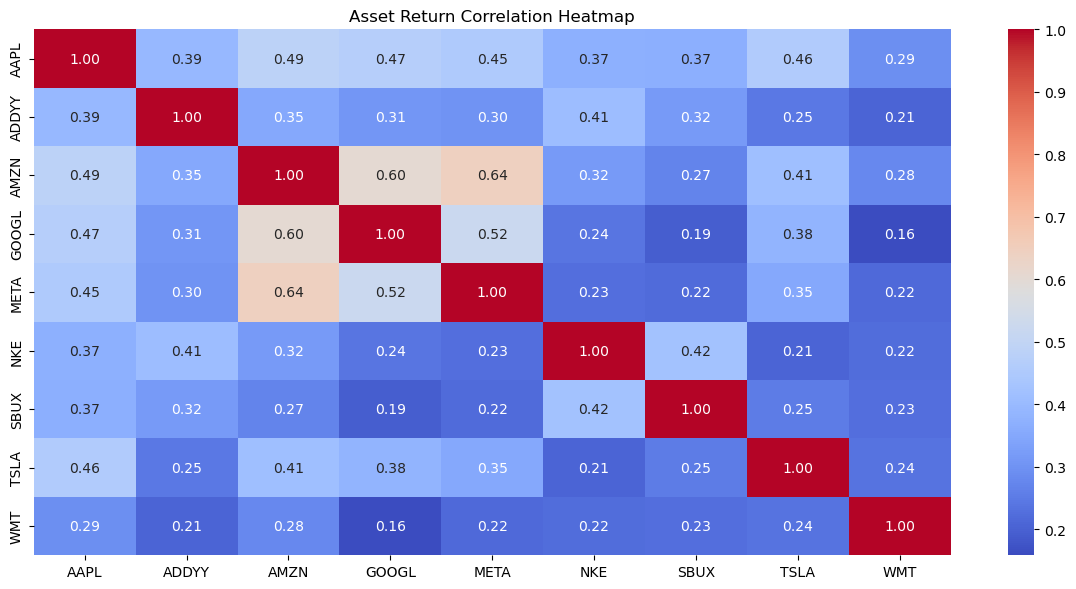

In [329]:
# Load historical log returns
returns_df = pd.read_csv("../data/historical_returns.csv", index_col=0, parse_dates=True)
corr_matrix = returns_df.corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Asset Return Correlation Heatmap")
plt.tight_layout()
plt.show()

**Rolling Volatility**

<Figure size 1200x600 with 0 Axes>

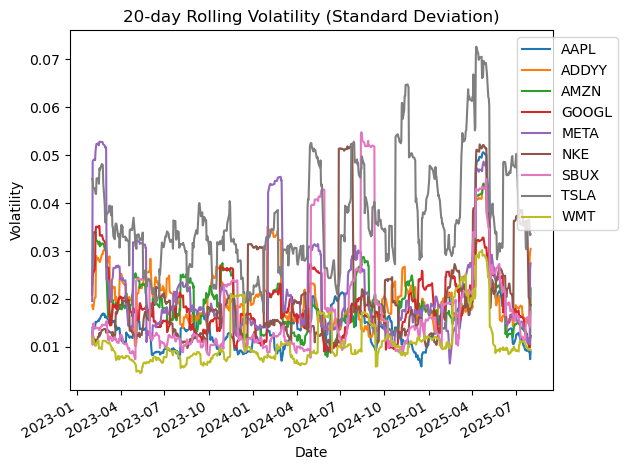

In [330]:
# Rolling 20-day standard deviation
rolling_vol = returns_df.rolling(window=20).std()

plt.figure(figsize=(12,6))
rolling_vol.plot()
plt.title('20-day Rolling Volatility (Standard Deviation)')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


# Realistic scenario

In [331]:
# Allocation of assets based on minimal equal weighting volatility
investments = np.array([225, 125, 75, 50, 100, 175, 125, 100, 25])
weights = investments / investments.sum()

# Create a clear display
tickers = ['AMZN', 'SBUX', 'NKE', 'AAPL', 'TSLA', 'GOOGL', 'META', 'WMT', 'ADDYY']
for ticker, weight in zip(tickers, weights):
    print(f"{ticker}: {weight:.4f}")

losses = simulate_portfolio_losses(mu, sigma, weights, T=10, N=10000)

var_95 = compute_var(losses, 0.95)
cvar_95 = compute_cvar(losses, 0.95)

print(f"We are 95% confident we will not lose more than {var_95 * 100:.4f}% over the next 10 days")
print(f"If things go worse than the 95% VaR then we expect an average loss of {cvar_95 * 100:.4f}%")

AMZN: 0.2250
SBUX: 0.1250
NKE: 0.0750
AAPL: 0.0500
TSLA: 0.1000
GOOGL: 0.1750
META: 0.1250
WMT: 0.1000
ADDYY: 0.0250
We are 95% confident we will not lose more than 6.8893% over the next 10 days
If things go worse than the 95% VaR then we expect an average loss of 8.7591%


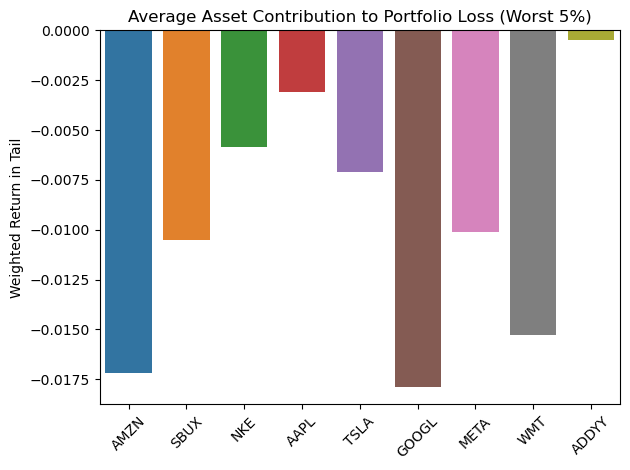

In [332]:

# Simulate all asset-level returns
simulated_returns = np.random.multivariate_normal(mu * 10, sigma * 10, size=100000)

# Get losses for each simulation
portfolio_returns = np.dot(simulated_returns, weights)
losses = -portfolio_returns

# Mask worst 5%
worst_idx = losses >= compute_var(losses, 0.95)
worst_returns = simulated_returns[worst_idx]  # shape (N_worst, d)

# Weighted contribution per asset
avg_contributions = worst_returns.mean(axis=0) * weights

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=tickers, y=avg_contributions)
plt.title("Average Asset Contribution to Portfolio Loss (Worst 5%)")
plt.ylabel("Weighted Return in Tail")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()